In [1]:
import warnings

warnings.filterwarnings("ignore")

# Reprojection and tiling

The `equi7grid` package offers utility functions to efficiently reproject geospatial imagery to the Equi7Grid. This process also includes slicing the reprojected image into smaller chunks represented by Equi7Grid tiles. 

The reprojection and tiling can be triggered using the `resample_to_equi7_tiles` function available in `equi7grid`'s `warp` module. `resample_to_equi7_tiles` has an extensive number of arguments described [here](https://tuw-geo.github.io/Equi7Grid/latest/apidocs/equi7grid/equi7grid.warp.html#equi7grid.warp.resample_to_equi7_tiles). Three arguments are mandatory: 

- the file path to the image (e.g., GeoTIFF, NetCDF)
- an `Equi7Grid` instance defining the available tiling levels and continents
- the path to the output directory

There are a few optional arguments to highlight:



:::{note}
`equi7grid`'s `warp` module requires additional depencies, which are not installed by default. You can install them via `uv pip install equi7grid[warp]`.
:::

Lets create an exemplary GeoTIFF file to be able to demonstrate how the resampling works. With the following function we write a GeoTIFF file using `rasterio`. The data is given in the webmercator projection, sampled with a 10km pixel size, and contains some classified values as _UInt8_.

In [2]:
import tempfile
from pathlib import Path

import numpy as np
import pyproj
import rasterio as rio
from rasterio.transform import from_bounds

tmp_dirpath = Path(tempfile.mkdtemp())
sample_filepath = tmp_dirpath / "webmercator_img_discrete.tif"
extent = (4_900_000, 7_810_000, 6_180_000, 8_750_000)
sampling = 10_000
nodata = 255
dtype = "uint8"
compress = "zstd"
sample_crs = pyproj.CRS.from_epsg(3857)

width, height = (
    int((extent[2] - extent[0]) / sampling),
    int((extent[3] - extent[1]) / sampling),
)
w_ar, h_ar = np.meshgrid(np.arange(width), np.arange(height))
ar = w_ar**2 + h_ar**2
ar[ar < (width + height)] = 0
ar[(ar >= (width + height)) & (ar < (width**2 + height))] = 1
ar[ar >= (width**2 + height)] = 2

transform = from_bounds(*extent, width, height)
kwargs = {}
kwargs.update(
    {
        "crs": sample_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "nodata": nodata,
        "dtype": dtype,
        "compress": compress,
        "count": 1,
    }
)

with rio.open(sample_filepath, "w", **kwargs) as rd:
    rd.write(ar.astype(np.uint8), 1)

After generating the data we can generate a small helper function to inspect the data using `cartopy`:

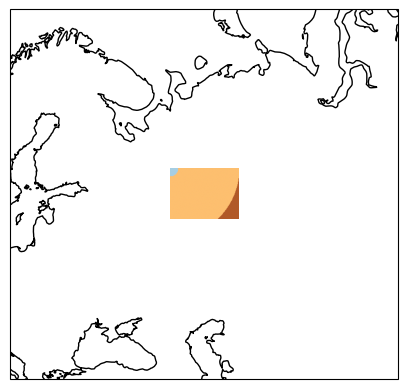

In [ ]:
from collections.abc import Sequence
from typing import cast

import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from pytileproj.projgeom import pyproj_to_cartopy_crs

extent_bfr = 3_000_000


def plot_img(filepath: Path, tiff_extent: Sequence[float], ax: GeoAxes) -> None:
    """Load masked image data and plot it on a map."""
    img = plt.imread(filepath)
    img_extent = [tiff_extent[0], tiff_extent[2], tiff_extent[1], tiff_extent[3]]
    img_ma = np.ma.array(img, fill_value=nodata, mask=img == nodata)
    ax.imshow(img_ma, extent=img_extent, origin="upper", cmap="Paired", vmin=0, vmax=2)


map_crs = pyproj_to_cartopy_crs(sample_crs)
fig = plt.figure()
ax = cast("GeoAxes", fig.add_subplot(1, 1, 1, projection=map_crs))
ax.coastlines()
map_extent = [
    extent[0] - extent_bfr,
    extent[2] + extent_bfr,
    extent[1] - extent_bfr,
    extent[3] + extent_bfr,
]
ax.set_extent(map_extent, crs=map_crs)
plot_img(sample_filepath, extent, ax)
plt.show()

Now we can create our `Equi7Grid` object, which defines the target projection and tiling scheme. The image above depicts already a special case, since it crosses the "EU" and "AS" continental boundary of the Equi7Grid. This means that by default, the image will be reprojected to both continental projections. In the following we only want to work with data in the "EU" system, which can be defined with the `continent_order` argument, we want to oversample the data to 3km, and work with "T6" tiles.

In [ ]:
from equi7grid import Equi7Grid, get_standard_equi7grid

e7grid = get_standard_equi7grid({"T6": 3_000}, continent_order=["EU"])

Finally, we create the output directory, set all desired arguments, and execute `resample_to_equi7_tiles`:

In [5]:
from equi7grid.warp import resample_to_equi7_tiles

out_dirpath = Path(tempfile.mkdtemp())
tile_filepaths = resample_to_equi7_tiles(
    sample_filepath,
    e7grid,
    out_dirpath,
    tiling_id="T6",
    accurate_boundary=True,
    compress_type="zstd",
)
tile_filepaths

[PosixPath('/tmp/tmp6kn6z9zr/EQUI7_EU/E066N030T6/webmercator_img_discrete_EU_E066N030T6.tif'),
 PosixPath('/tmp/tmp6kn6z9zr/EQUI7_EU/E072N030T6/webmercator_img_discrete_EU_E072N030T6.tif'),
 PosixPath('/tmp/tmp6kn6z9zr/EQUI7_EU/E066N024T6/webmercator_img_discrete_EU_E066N024T6.tif'),
 PosixPath('/tmp/tmp6kn6z9zr/EQUI7_EU/E072N024T6/webmercator_img_discrete_EU_E072N024T6.tif')]

The image has been sliced into four tiles in the "EU" Equi7Grid projection. Lets take a look at the resampled data:

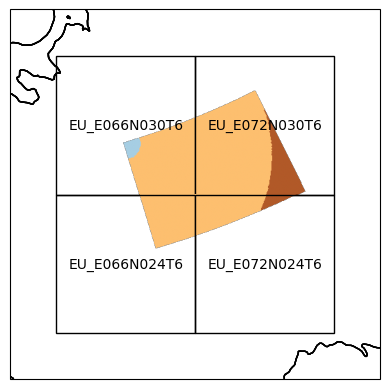

In [ ]:
extent_bfr = 200_000


def plt_e7_tiled_data(
    tile_filepaths: list[str], e7grid: Equi7Grid, continent: str
) -> None:
    """Plot tiled image data located in the Equi7Grid."""
    map_crs = pyproj_to_cartopy_crs(e7grid[continent].pyproj_crs)
    fig = plt.figure()
    ax = cast("GeoAxes", fig.add_subplot(1, 1, 1, projection=map_crs))
    ax.coastlines()
    min_x = 1e12
    max_x = 0
    min_y = 1e12
    max_y = 0
    for tile_filepath in tile_filepaths:
        tilename = tile_filepath.stem[-13:]
        tile = e7grid.get_tile_from_name(tilename)
        plot_img(Path(tile_filepath), tile.outer_boundary_extent, ax)
        min_x = min(min_x, tile.ll_x)
        min_y = min(min_y, tile.ll_y)
        max_x = max(max_x, tile.ur_x)
        max_y = max(max_y, tile.ur_y)
        tile.plot(ax=ax, label_tile=True, facecolor="None")
    map_extent = [
        min_x - extent_bfr,
        max_x + extent_bfr,
        min_y - extent_bfr,
        max_y + extent_bfr,
    ]
    ax.set_extent(map_extent, crs=map_crs)
    plt.show()


plt_e7_tiled_data(tile_filepaths, e7grid, "EU")

## Specify tiles

If we are only interested in (a) specific tile(s), we can specify them as an argument:

In [7]:
e7grid = get_standard_equi7grid({"T6": 3_000})
tile_filepaths = resample_to_equi7_tiles(
    sample_filepath,
    e7grid,
    out_dirpath,
    tiling_id="T6",
    accurate_boundary=True,
    compress_type="zstd",
    ftilenames=["AS_E012N066T6", "AS_E018N066T6"],
)
tile_filepaths

[PosixPath('/tmp/tmp6kn6z9zr/EQUI7_AS/E012N066T6/webmercator_img_discrete_AS_E012N066T6.tif'),
 PosixPath('/tmp/tmp6kn6z9zr/EQUI7_AS/E018N066T6/webmercator_img_discrete_AS_E018N066T6.tif')]

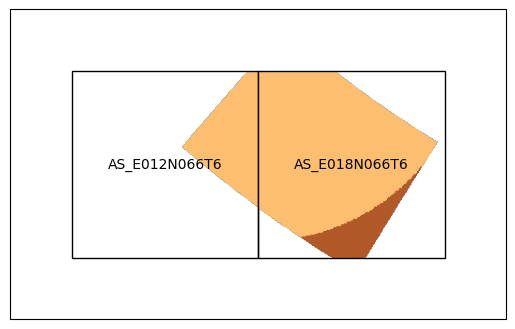

In [8]:
plt_e7_tiled_data(tile_filepaths, e7grid, "AS")

## Specify naming convention

If you want to change the standard naming: [filename]_[full tilename].[suffix] to something else, you can create your own naming convention. To do so, you need to define a function with the filepath of the input image and the full tilename as arguments. 

In [1]:
def my_naming_convention(filepath: Path, ftilename: str) -> str:
    """Define own naming convention."""
    return f"{ftilename}_for_my_new_file{filepath.suffix}"


tile_filepaths = resample_to_equi7_tiles(
    sample_filepath,
    e7grid,
    out_dirpath,
    tiling_id="T6",
    accurate_boundary=True,
    compress_type="zstd",
    naming_traffo=my_naming_convention,
)
tile_filepaths

NameError: name 'Path' is not defined